<a href="https://colab.research.google.com/github/mariannaflores/final_eml/blob/main/proyecto_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Proyecto Final - Machine Learning Models
## MODELO DE PREDICCION DE NOMBRE SEGUN COLOR DE PINTURA DE UNAS

**NECESIDAD:** Usualmente a uno le gusta usar pinturas de uñas de colores similares o cierta gama particular, pero es altamente complicado pues los nombres parecen no tener sentido o relacion con el color.

**OBJETIVO PROYECTO:** Desarrollar un sistema de recomendacion que al ingresar una categoria o rama de colores recomiende los mas populares o los mas similares a el color.

**METODOLOGIA:** Uso de redes neurales para optimizar las relaciones entre los datos de los colores, que suelen ser muy complejos y desarrollar dos modelos.
  1. Recomendacion por popularidad de color   2. Recomendacion por codigo de color.

#### LIBRERIAS

In [1]:
pip install category_encoders

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

#Preparacion de variables
import category_encoders as ce
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder

#Modelos de neural networks
from keras.models import Model
from keras.layers import Input, Reshape, Dot
from keras.layers.embeddings import Embedding
from keras.optimizers import Adam
from keras.regularizers import l2
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf

### UPLOAD DATASET

In [3]:
#df = pd.read_csv('/Users/maria/OneDrive/Documentos/mle_laboratorios/Final/final_eml/dataset.csv')
#df.head()

from google.colab import files
uploaded = files.upload()

Saving dataset.csv to dataset (5).csv


In [4]:
import io
df = pd.read_csv(io.BytesIO(uploaded['dataset.csv']))
df.head()

,name,type,score,raitings,hex,rgb,category,marca
0,sheer luck,classic,5.0,3.0,#f4e1e8,"rgb(244,225,225)",sheers,essie
1,always transparent,exprclassic,0.0,0.0,#fafbf8,"rgb(250,251,251)",sheers,essie
2,tuck it in my tux,classic,3.4,15.0,#f5f1ee,"rgb(245,241,241)",sheers,essie
3,desk mani,exprclassic,0.0,0.0,#f78963,"rgb(247,137,137)",sheers,essie
4,marshmallow,classic,4.4,83.0,#f1e6e3,"rgb(240,228,228)",sheers,essie


Se separa categoria y marca para agregar a la matriz de recomendacion despues

In [5]:
categ = df[['category','marca']]

### PREPROCESADO

#### PREPARACION COLUMNA CODIGO RGB

La columna de rgb tiene que procesarse separando por cada componente de color (red, green, blue)

In [6]:
codigo = df["rgb"]

remove = ['rgb']
remove2 = ['(']
remove3 = [')']

for i in remove:
    s1 = codigo.str.replace(i, '')

for j in remove2:
    s2 = s1.str.replace(j, '')


for k in remove3:
    s3 = s2.str.replace(k, '')

colores = s3.str.split(",", n = 2, expand = True)
colores.head()

,0,1,2
0,244,225,225
1,250,251,251
2,245,241,241
3,247,137,137
4,240,228,228


In [7]:
df = df.drop(['rgb'], axis=1)
df = pd.concat([df, colores], axis=1)
df = df.rename({0:"r", 1:"g", 2:"b"}, axis='columns')

Se agrega indice para identificar cada pintura de uñas en el analisis de la red neuronal

In [8]:
df['index'] = df.index

#### ENCODING VARIABLES CATEGORICAS

Se emplea *encoding ordinal* para mantener una sola columna con los valores de cada columna

In [9]:
ce_ord = ce.OrdinalEncoder(cols = ['type', 'category', 'marca'])
df = ce_ord.fit_transform(df)
df.head()

,name,type,score,raitings,hex,category,marca,r,g,b,index
0,sheer luck,1,5.0,3.0,#f4e1e8,1,1,244,225,225,0
1,always transparent,2,0.0,0.0,#fafbf8,1,1,250,251,251,1
2,tuck it in my tux,1,3.4,15.0,#f5f1ee,1,1,245,241,241,2
3,desk mani,2,0.0,0.0,#f78963,1,1,247,137,137,3
4,marshmallow,1,4.4,83.0,#f1e6e3,1,1,240,228,228,4


### PESOS PARA VALUAR MATRIZ POR RATING Y POR COLOR

Para poder medir tanto en ratings como por color es necesario establecer una metrica.
Se definieron dos modelos segun la informacion obtenida en el dataset:
1. **Ratings:** las paginas web de pinturas de uñas tenian ratings de usuarios previos que se usaron como metodo de medicion para recomendar nuevas pinturas de uñas de distintas categorias
2. **Codigo de color:** El codigo de color como tal es muy extenso y complejo para analizar, por ende se realizo una metrica compuesto de los 3 colores.
Ecuacion: rrr + ggg00 + bbb0000, los colores mas rojos seran mas pequeños y entre mas azules mas grandes.

In [10]:
#pesos de ratings por clientes y colores de pintura
m=df['raitings'].quantile(0.9)
C=df['score'].mean()

def peso_scores(x, m=m, C=C):
    v = x['raitings']
    R = x['score']
    return (v/(v+m) * R) + (m/(m+v) * C)

df['weight'] = df.apply(peso_scores, axis=1)

In [11]:
#metrica de cada color por presencia de colores
df['r'] = df['r'].astype(int)
df['g'] = df['g'].astype(int)
df['b'] = df['b'].astype(int)

df['color'] = df['r'] + df['g']*100 + df['b']*10000

### SEPARACION DE VARIABLES X Y Y 

Se separaron las variables dos veces por los dos modelos empleados, uno con peso de ratings y otro con codigo de color.
> Se normalizo la variable "y" con datos entre 0 y 1 para el entrenamiento


In [12]:
min1 = min(df["weight"])
max1 = max(df["weight"])

x1 = df[["category", "index"]].values
y1 = df["weight"].apply(lambda x: (x - min1) / (max1 - min1)).values

x_train1, x_cv1, x_test1 = np.split(x1, 
                       [int(.3333*len(x1)), int(.6666*len(x1))])
y_train1, y_cv1, y_test1 = np.split(y1, 
                       [int(.3333*len(y1)), int(.666*len(y1))])

y_test1 = y_test1[0:336]
x_cv1 = x_cv1[0:336]
x_test1 = x_test1[0:336]

In [13]:
min2 = min(df["color"])
max2 = max(df["color"])

x2 = df[["category", "index"]].values
y2 = df["color"].apply(lambda x: (x - min2) / (max2 - min2)).values

x_train2, x_cv2, x_test2 = np.split(x2, 
                       [int(.3333*len(x2)), int(.6666*len(x2))])
y_train2, y_cv2, y_test2 = np.split(y2, 
                       [int(.3333*len(y2)), int(.666*len(y2))])

y_test2 = y_test2[0:336]
x_cv2 = x_cv2[0:336]
x_test2 = x_test2[0:336]

### PREPARACION MATRICES MODELOS

In [14]:
categoria = df['category'].nunique()+1
pinturas = df['index'].nunique()

In [15]:
df1 = df[['category','index','weight']] #para modelo1
df2 = df[['category', 'index', 'color']] #para modelo2
info_np = df[['index','name']] 
info_np = pd.concat([info_np, categ], axis = 1) #matriz con informacion por item

In [16]:
user_ids = df1["category"].unique().tolist()
user2user_encoded = {x: i for i, x in enumerate(user_ids)}
userencoded2user = {i: x for i, x in enumerate(user_ids)}

items_ids = df1["index"].unique().tolist()
item2item_encoded = {x: i for i, x in enumerate(items_ids)}
item_encoded2item = {i: x for i, x in enumerate(items_ids)}

### FUNCIONES REDES NEURALES


*   **Funcion activacion - sigmoide:** sigmoid(x) = 1 / (1 + exp(-x))
*   **Loss - mean_squared_error:** cantidad que el modelo debe minimizar en training. Este encuentra el cuadrado de la diferencia entre el las predicciones y observaciones reales.
*   **Optimizer - Adam:** algoritmo optimizador de stochastic gradient descent.
*   **Bias:** constante de input



In [17]:
class RecommenderNet(keras.Model):
    def __init__(self, usuario, items, embedding_size, **kwargs):
        super(RecommenderNet, self).__init__(**kwargs)
        self.usuario = usuario
        self.items = items
        self.embedding_size = embedding_size
        self.user_embedding = layers.Embedding(
            usuario,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        self.user_bias = layers.Embedding(usuario, 1)
        self.item_embedding = layers.Embedding(
            items,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        self.item_bias = layers.Embedding(items, 1)

    def call(self, inputs):
        user_bias = self.user_bias(inputs[:, 0])
        item_bias = self.item_bias(inputs[:, 1])
        user_vector = self.user_embedding(inputs[:, 0])
        item_vector = self.item_embedding(inputs[:, 1])
        prod_punto = tf.tensordot(user_vector, item_vector, 2)
        x = prod_punto + user_bias + item_bias
        x = Activation('sigmoid')(x)
        return (x)


In [18]:
model = RecommenderNet(categoria, pinturas, 50)
model.compile(
    loss='mean_squared_error', optimizer=Adam(lr=0.001)
)

### MODELO 1 - SISTEMA DE RECOMENDACION BASADO EN CATEGORIAS DE COLORES

In [19]:
history = model.fit(
    x=x_train1,
    y=y_train1,
    batch_size=10,
    epochs=50,
    verbose=1,
    validation_data=(x_cv1, y_cv1),
)

Epoch 1/50
34/34 [==============================] - 2s 23ms/step - loss: 0.0384 - val_loss: 0.0359
Epoch 2/50
34/34 [==============================] - 0s 4ms/step - loss: 0.0217 - val_loss: 0.0341
Epoch 3/50
34/34 [==============================] - 0s 4ms/step - loss: 0.0170 - val_loss: 0.0326
Epoch 4/50
34/34 [==============================] - 0s 4ms/step - loss: 0.0155 - val_loss: 0.0313
Epoch 5/50
34/34 [==============================] - 0s 3ms/step - loss: 0.0186 - val_loss: 0.0303
Epoch 6/50
34/34 [==============================] - 0s 4ms/step - loss: 0.0157 - val_loss: 0.0296
Epoch 7/50
34/34 [==============================] - 0s 3ms/step - loss: 0.0171 - val_loss: 0.0291
Epoch 8/50
34/34 [==============================] - 0s 3ms/step - loss: 0.0186 - val_loss: 0.0287
Epoch 9/50
34/34 [==============================] - 0s 4ms/step - loss: 0.0157 - val_loss: 0.0284
Epoch 10/50
34/34 [==============================] - 0s 4ms/step - loss: 0.0168 - val_loss: 0.0282
Epoch 11/50
34/34 

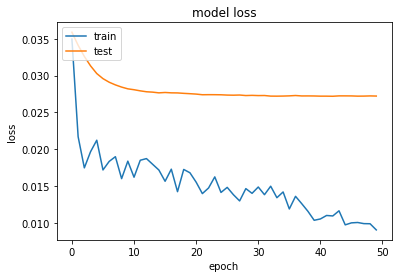

In [20]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()

#### TESTING MODELO 1

**Categorias**
1. sheers
2. whites
3. nudes 
4. pinks 
5. corals 
6. reds 
7. purples
8. blues 
9. greens 
10. yellows 
11. grays 
12. oranges 
13. browns
14. blacks 
15. coral
Las siguientes categorias son seleccionadas random para obtener recomendaciones basadas en ratings y colores

In [21]:
#numero de categoria random o seleccionado
cat = df.category.sample(1).iloc[0]

In [25]:
np_category = df[df.category == cat]
np_not_category = info_np[
    ~info_np["index"].isin(np_category.index.values)
]["index"]
np_not_category = list(
    set(np_not_category).intersection(set(item2item_encoded.keys()))
)
np_not_category = [[item2item_encoded.get(x
)] for x in np_not_category]
user_encoder = user2user_encoded.get(cat)
user_item_array = np.hstack(
    ([[user_encoder]] * len(np_not_category), np_not_category)
)

ratings = model.predict(user_item_array).flatten()
top_ratings_indices = ratings.argsort()[-10:][::-1]
recommended_item_ids = [
    item_encoded2item.get(np_not_category[x][0]) for x in top_ratings_indices
]

print("Mas recomendadas categoria: {}".format(cat))
print("=" * 35)
top_np_user = (
    np_category.sort_values(by="weight", ascending=False)
    .head(5)
    .index.values
)
info_np1 = info_np[info_np["index"].isin(top_np_user)]
for row in info_np1.itertuples():
    print(row.name, "| categoria:", row.category," | marca:" ,row.marca)

print(" " * 35)
print(" " * 35)
print("Top 10 recomendaciones")
print("----" * 8)
recommended_nailpolish = info_np[info_np["index"].isin(recommended_item_ids)]
for row in recommended_nailpolish.itertuples():
    print(row.name, "| categoria:", row.category," | marca:" ,row.marca)

Mas recomendadas categoria: 9
chillato | categoria: greens  | marca: essie
precious cargo-go | categoria: greens  | marca: essie
mint candy apple | categoria: greens  | marca: essie
mojito medness | categoria: greens  | marca: essie
naughty nautical | categoria: greens  | marca: essie
                                   
                                   
Top 10 recomendaciones
--------------------------------
marshmallow | categoria: sheers  | marca: essie
ballet slippers | categoria: sheers  | marca: essie
wild nude | categoria: nudes  | marca: essie
mod square | categoria: pinks  | marca: essie
sheer fantasy | categoria: pinks  | marca: essie
watermelon | categoria: pinks  | marca: essie
couture curator  | categoria: corals  | marca: essie
cute as a button | categoria: corals  | marca: essie
wicked | categoria: reds  | marca: essie
wicked remix | categoria: reds  | marca: essie


### MODELO 2 - SISTEMA DE RECOMENDACION BASADO EN CODIGO RGB

In [26]:
history = model.fit(
    x=x_train2,
    y=y_train2,
    batch_size=10,
    epochs=50,
    verbose=1,
    validation_data=(x_cv2, y_cv2),
)

Epoch 1/50
34/34 [==============================] - 0s 5ms/step - loss: 0.0975 - val_loss: 0.0655
Epoch 2/50
34/34 [==============================] - 0s 4ms/step - loss: 0.0893 - val_loss: 0.0654
Epoch 3/50
34/34 [==============================] - 0s 4ms/step - loss: 0.0808 - val_loss: 0.0654
Epoch 4/50
34/34 [==============================] - 0s 4ms/step - loss: 0.0773 - val_loss: 0.0654
Epoch 5/50
34/34 [==============================] - 0s 4ms/step - loss: 0.0685 - val_loss: 0.0655
Epoch 6/50
34/34 [==============================] - 0s 4ms/step - loss: 0.0667 - val_loss: 0.0655
Epoch 7/50
34/34 [==============================] - 0s 4ms/step - loss: 0.0613 - val_loss: 0.0654
Epoch 8/50
34/34 [==============================] - 0s 4ms/step - loss: 0.0547 - val_loss: 0.0654
Epoch 9/50
34/34 [==============================] - 0s 3ms/step - loss: 0.0586 - val_loss: 0.0654
Epoch 10/50
34/34 [==============================] - 0s 3ms/step - loss: 0.0520 - val_loss: 0.0654
Epoch 11/50
34/34 [

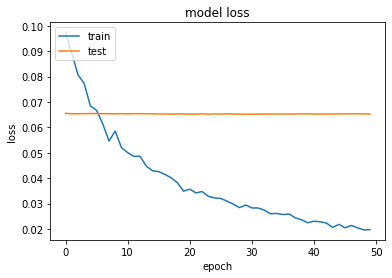

In [27]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()

#### TESTING MODELO 2

In [32]:
ratings = model.predict(user_item_array).flatten()
top_ratings_indices = ratings.argsort()[-10:][::-1]
recommended_item_ids = [
    item_encoded2item.get(np_not_category[x][0]) for x in top_ratings_indices
]

print("Mas recomendadas color mas cercano: {}".format(cat))
print("=" * 35)

top_item_user = (
    np_category.sort_values(by="color", ascending=False)
    .head(5)
    .index.values
)
info_np1 = info_np[info_np["index"].isin(top_item_user)]
for row in info_np1.itertuples():
    print(row.name, "| categoria:", row.category," | marca:" ,row.marca)

print(" " * 35)
print(" " * 35)
print("Top 10 recomendaciones color")
print("----" * 8)

recommended_nailpolish = info_np[info_np["index"].isin(recommended_item_ids)]
for row in recommended_nailpolish.itertuples():
    print(row.name, "| categoria:", row.category," | marca:" ,row.marca)

Mas recomendadas color mas cercano: 9
chillato | categoria: greens  | marca: essie
seas the day | categoria: greens  | marca: essie
peppermint condition | categoria: greens  | marca: essie
express to impress | categoria: greens  | marca: essie
smoldering teal | categoria: greens  | marca: sally hansen
                                   
                                   
Top 10 recomendaciones color
--------------------------------
marshmallow | categoria: sheers  | marca: essie
blanc | categoria: whites  | marca: essie
diamond in the cuff | categoria: whites  | marca: essie
ballet slippers remixed | categoria: pinks  | marca: essie
matter of fiction | categoria: pinks  | marca: essie
romper room  | categoria: pinks  | marca: essie
muchi, muchi | categoria: pinks  | marca: essie
sheer fantasy | categoria: pinks  | marca: essie
couture curator  | categoria: corals  | marca: essie
lilacism | categoria: purples  | marca: essie
